<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/Weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# connect googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import re

# intake24
file_path = '/content/drive/MyDrive/UPF-HFI/NOVA classification/outcome/intake24_with_nova.xlsx'
df = pd.read_excel(file_path)

# Create a helper function: return the day of the week based on the content of DAYCHANGE
def extract_weekday(value):
    if pd.isna(value):
        return np.nan
    # Numbers (Excel dates)
    if isinstance(value, (int, float)):
        try:
            date = pd.to_datetime('1899-12-30') + pd.to_timedelta(value, unit='D')
            return date.day_name()# Return Monday to Sunday
        except:
            return np.nan
    # string (try to extract the day of the week)
    elif isinstance(value, str):
        match = re.search(r'(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)', value)
        if match:
            return match.group(1)
    return np.nan

df['Actual_Weekday'] = df['DAYCHANGE'].apply(extract_weekday)

# If Actual_Weekday is empty (indicating no DAYCHANGE information), use DAY to complete it.
df['DAY_clean'] = df['DAY'].astype(str).str.extract(r'(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)', expand=False)
df['Actual_Weekday'] = df['Actual_Weekday'].fillna(df['DAY_clean'])

# Revised_WeekdayType
df['Revised_WeekdayType'] = df['Actual_Weekday'].apply(
    lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else ('Weekday' if pd.notna(x) else np.nan)
)


In [4]:
# Filter out key columns for manual inspection
cols_to_check = [
    'UserID_clean',
    'DAYCHANGE',
    'DAY',
    'Actual_Weekday',
    'Revised_WeekdayType'
]

check_df = df[cols_to_check].copy()

# save
check_df.to_excel(
    '/content/drive/MyDrive/UPF-HFI/Model/outcome/check/check_weekdaytype.xlsx',
    index=False
)

print("Exported to intake24_check_weekdaytype.xlsx")


Exported to intake24_check_weekdaytype.xlsx


In [6]:
# Export the complete intake24 table
df.to_excel(
    '/content/drive/MyDrive/UPF-HFI/Model/outcome/intake24_cleaned_with_weekdaytype.xlsx',
    index=False
)

print("The entire table intake24_cleaned_with_weekdaytype.xlsx has been exported successfully")


The entire table intake24_cleaned_with_weekdaytype.xlsx has been exported successfully


# Weighted_upf_percent

In [7]:
import pandas as pd

# read
file_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/intake24_cleaned_with_weekdaytype.xlsx"
df = pd.read_excel(file_path)

# === Step 1: Type Conversion ===
df['Revised_WeekdayType'] = df['Revised_WeekdayType'].astype(str)
df['Energykcal'] = pd.to_numeric(df['Energykcal'], errors='coerce')
df['NOVA'] = pd.to_numeric(df['NOVA'], errors='coerce')

# === Step 2: Calculate the total energy of weekday/weekend ===
total_kcal = df.groupby(['UserID_clean', 'Revised_WeekdayType'])['Energykcal'].sum().unstack(fill_value=0).reset_index()
total_kcal.rename(columns={'Weekday': 'weekday_kcal', 'Weekend': 'weekend_kcal'}, inplace=True)

# === Step 3: Calculate the total UPF energy of weekday/weekend (NOVA=4) ===
upf_df = df[df['NOVA'] == 4]
upf_kcal = upf_df.groupby(['UserID_clean', 'Revised_WeekdayType'])['Energykcal'].sum().unstack(fill_value=0).reset_index()
upf_kcal.rename(columns={'Weekday': 'weekday_upf_kcal', 'Weekend': 'weekend_upf_kcal'}, inplace=True)

# === Step 4: Merge Data ===
merged = pd.merge(total_kcal, upf_kcal, on='UserID_clean', how='outer').fillna(0)

# === Step 5: Calculate weighted total energy and weighted UPF ===
merged['weighted_kcal'] = 5/7 * merged['weekday_kcal'] + 2/7 * merged['weekend_kcal']
merged['weighted_upf_kcal'] = 5/7 * merged['weekday_upf_kcal'] + 2/7 * merged['weekend_upf_kcal']

# === Step 6: Calculate UPF percentage ===
merged['weighted_upf_percent'] = (merged['weighted_upf_kcal'] / merged['weighted_kcal']) * 100

# === Step 7: Export ===
merged.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx", index=False)
print("weighted_upf_percent exported successfully!")


weighted_upf_percent exported successfully!


In [8]:
# Merge into intake24
df = pd.merge(df, merged[['UserID_clean', 'weighted_upf_percent']], on='UserID_clean', how='left')
df.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/intake24_cleaned_with_weighted_upf_percent.xlsx", index=False)
print("intake24_upf_percent exported successfully")

intake24_upf_percent exported successfully


# weighted_score

In [9]:
import pandas as pd

# === Step 0: Import intake24 data ===
file_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/intake24_cleaned_with_weekdaytype.xlsx"
intake_df = pd.read_excel(file_path)

# Convert related columns to numerical values to prevent non-numerical values from interfering with calculations
intake_df["Energykcal"] = pd.to_numeric(intake_df["Energykcal"], errors="coerce")
intake_df["NOVA"] = pd.to_numeric(intake_df["NOVA"], errors="coerce")

# === Step 1: Mark NOVA weights ===
nova_weights = {1: 1, 2: 2, 3: 3, 4: 4}
intake_df["UPF_weight"] = intake_df["NOVA"].map(nova_weights)

# === Step 2: Calculate the weighted score for each record ===
intake_df["weighted_score"] = intake_df["Energykcal"] * intake_df["UPF_weight"]

# === Step 3: Group by UserID_clean and Revised_WeekdayType, calculate total energy and score ===
agg_df = (
    intake_df
    .groupby(["UserID_clean", "Revised_WeekdayType"])
    .agg(
        total_kcal=("Energykcal", "sum"),
        weighted_kcal=("weighted_score", "sum")
    )
    .reset_index()
)

# === Step 4: Calculate the weighted score ratio for each group ===
agg_df["score_ratio"] = agg_df["weighted_kcal"] / agg_df["total_kcal"]

# === Step 5: Split into weekday and weekend and take weighted average ===
weekday = agg_df[agg_df["Revised_WeekdayType"] == "Weekday"][["UserID_clean", "score_ratio"]].rename(columns={"score_ratio": "weekday_score"})
weekend = agg_df[agg_df["Revised_WeekdayType"] == "Weekend"][["UserID_clean", "score_ratio"]].rename(columns={"score_ratio": "weekend_score"})

# Merge two subtables and fill missing values with 0
merged = pd.merge(weekday, weekend, on="UserID_clean", how="outer").fillna(0)

# === Step 6: Weighted average synthesis of the final score (5:2 weighting) ===
merged["weighted_upf_score"] = merged["weekday_score"] * 5/7 + merged["weekend_score"] * 2/7

# === Step 7: Export results ===
output_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_score.xlsx"
merged.to_excel(output_path, index=False)

print("Successfully exported weighted_upf_score.xlsx")


Successfully exported weighted_upf_score.xlsx


In [11]:
# Merge into intake24
df = pd.merge(df, merged[['UserID_clean', 'weighted_upf_score']], on='UserID_clean', how='left')
df.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/intake24_cleaned_with_weighted_upf_score.xlsx", index=False)
print("intake24_weighted_score successfully exported")

intake24_weighted_score successfully exported


# Select a dependent variable that is sensitive to HFI

In [12]:
# survey
survey_path = "/content/drive/MyDrive/UPF-HFI/Bradford_original data/4. SurveyMasterfile_clean.xlsx"
survey_df = pd.read_excel(survey_path)

hfi_columns = ['insecurity1', 'insecurity2', 'insecurity3', 'insecurity3a', 'insecurity4', 'insecurity5']

# Scoring function: 1, 2 => 1 point, the rest (3, 4) are 0 points
def score_response(x):
    return 1 if x in [1, 2] else 0

# Create HFI total score
survey_df['HFI_score'] = survey_df[hfi_columns].applymap(score_response).sum(axis=1)

# Create a binary variable (score >= 2 for food insecurity)
survey_df['HFI_binary'] = survey_df['HFI_score'].apply(lambda x: 1 if x >= 2 else 0)

# Keep useful columns
hfi_df = survey_df[['UserID_clean', 'HFI_score', 'HFI_binary']]

/tmp/ipython-input-3057564186.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  survey_df['HFI_score'] = survey_df[hfi_columns].applymap(score_response).sum(axis=1)


In [13]:
# UPF
upf_percent = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")
upf_score = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_score.xlsx")

# Merge two UPF metrics
upf = pd.merge(upf_percent, upf_score, on="UserID_clean", how="inner")

# Merge HFI indicator
merged = pd.merge(upf, hfi_df, on="UserID_clean", how="inner")


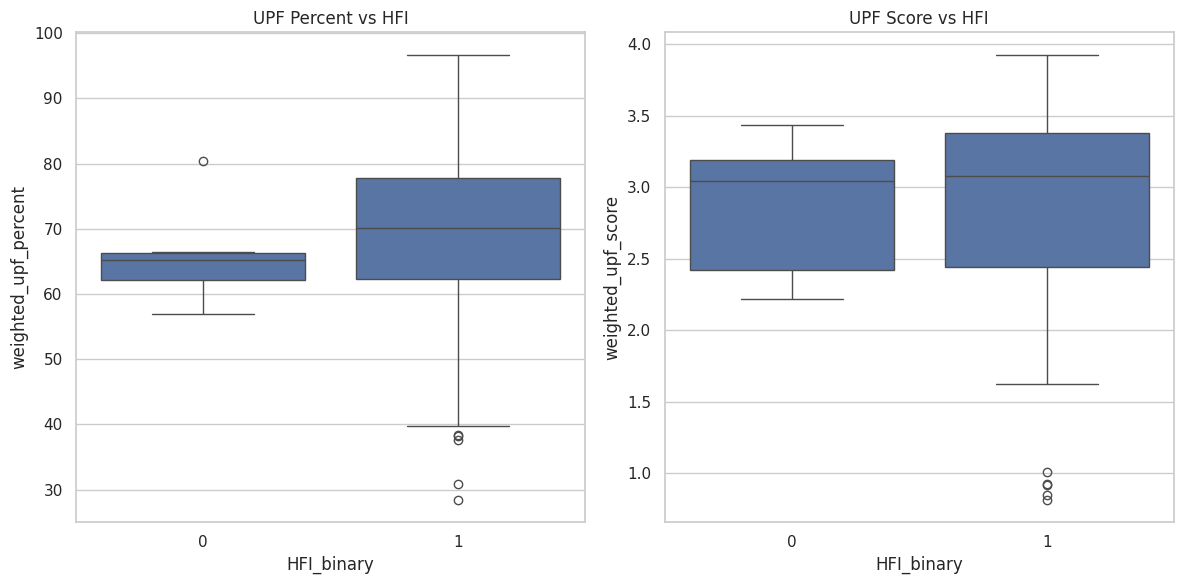

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Percentage box plot
sns.boxplot(data=merged, x="HFI_binary", y="weighted_upf_percent", ax=axes[0])
axes[0].set_title("UPF Percent vs HFI")

# Intensity score box plot
sns.boxplot(data=merged, x="HFI_binary", y="weighted_upf_score", ax=axes[1])
axes[1].set_title("UPF Score vs HFI")

plt.tight_layout()
plt.show()


# Mann-Whitney

In [15]:
from scipy.stats import mannwhitneyu

# Group by HFI
group0 = merged[merged['HFI_binary'] == 0]
group1 = merged[merged['HFI_binary'] == 1]

# Statistical tests
p_percent = mannwhitneyu(group0['weighted_upf_percent'], group1['weighted_upf_percent']).pvalue
p_score = mannwhitneyu(group0['weighted_upf_score'], group1['weighted_upf_score']).pvalue

print(f"UPF percentage p-value: {p_percent:.4f}")
print(f"UPF strength score p-value: {p_score:.4f}")

UPF percentage p-value: 0.2695
UPF strength score p-value: 0.6463
